In [1]:
# libraries 
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# Analysing Stocks:
## 1. Preparing data - 


In [2]:
# reading nifty-50 & preparing symbols
nifty50 = pd.read_csv("../data/nifty_200.csv")
symbols = nifty50["Symbol"] + ".NS"
symbols = symbols.to_list()

symbols.index("SBIN.NS")

165

In [3]:
# choose a random stock, let's take 15th share
sym = symbols[14]
print(f"downloading {sym} stocks data ...")
data = yf.download(sym, start="2010-01-01", end="2023-12-26")
data.index.names = ['date']
data.columns = data.columns.str.lower()
data = data.round(2)
data

downloading AMBUJACEM.NS stocks data ...
[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2010-01-04,105.40,106.60,103.50,106.10,81.37,1443914
2010-01-05,107.00,107.95,104.50,105.30,80.75,1529807
2010-01-06,105.35,106.85,103.55,105.95,81.25,1558825
2010-01-07,106.80,107.40,105.00,105.80,81.14,787351
2010-01-08,105.70,106.65,105.00,105.90,81.22,838294
...,...,...,...,...,...,...
2023-12-18,530.00,532.50,524.30,525.65,525.65,2875095
2023-12-19,528.40,530.55,517.00,522.35,522.35,2762093
2023-12-20,524.00,526.30,486.00,490.45,490.45,5434428


## 2. getting insights of data:
Since closing price is the most importe=ant indicator let's find out what can find out from it.

In [4]:
# finding out adj close
data['adj close'].describe()

count    3450.000000
mean      216.879336
std       104.154973
min        76.420000
25%       154.050000
50%       188.130000
75%       235.597500
max       580.970000
Name: adj close, dtype: float64

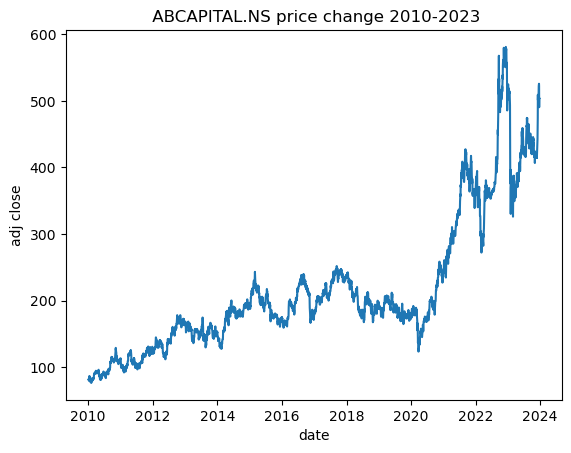

In [5]:
# see its past performance 
sn.lineplot(data=data['adj close'])
plt.title(f" {symbols[11]} price change 2010-2023")
plt.show()

### let's fit it into normal distribution
since we know
$$
price \approx N(\mu, \sigma)
$$
*To know more about Normal distribution visit [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)

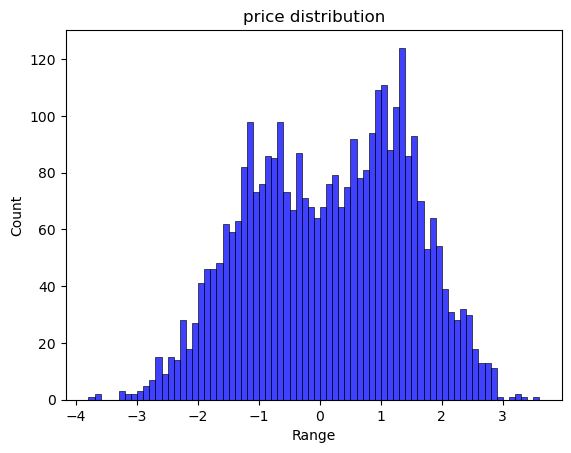

In [8]:
# let's calculate 20 day moivng average and fit normalize it with 20-day MA and std
mean = 20

ma_20 = data['adj close'].rolling(mean).mean()
std = data['adj close'].rolling(mean).std()

# normalize the price
n_close = (data['adj close'] - ma_20) / std

# now visualize it 
sn.histplot(n_close, binwidth=0.1, color="blue")
plt.title("price distribution")
plt.ylabel("Count")
plt.xlabel("Range")

plt.show()

### Conclusion:
+ we can bound price based on std, as we see in above fig that most of the price bounded between -3 to 3, when we take mean of past 20 period moving average.

# Makinga basic strategy based above conclusion 
strategy:
1. let's make bound on price.
2. then buy when price crossabove lower bound from below, similarly sell on price crossbelow upper bound from above.
3. calculate profit and max drawdown.


In [27]:
# backtesting the strategy

# making bound on the price 
period = 20
times = 1
data['lb'] = data['adj close'] -  times * data['adj close'].rolling(period).std()            # making lower bound on the price
data['ub'] = data['adj close'] +  times * data['adj close'].rolling(period).std()            # making upper bound on the price

data


,open,high,low,close,adj close,volume,lb,ub
date,,,,,,,,
2010-01-04,105.400002,106.599998,103.500000,106.099998,81.368477,1443914,NaN,NaN
2010-01-05,107.000000,107.949997,104.500000,105.300003,80.754929,1529807,NaN,NaN
2010-01-06,105.349998,106.849998,103.550003,105.949997,81.253433,1558825,NaN,NaN
2010-01-07,106.800003,107.400002,105.000000,105.800003,81.138420,787351,NaN,NaN
2010-01-08,105.699997,106.650002,105.000000,105.900002,81.215111,838294,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-18,530.000000,532.500000,524.299988,525.650024,525.650024,2875095,482.858421,568.441628
2023-12-19,528.400024,530.549988,517.000000,522.349976,522.349976,2762093,479.637057,565.062894
2023-12-20,524.000000,526.299988,486.000000,490.450012,490.450012,5434428,449.645406,531.254618


In [37]:
data.iloc[20]

open             102.45
high             103.60
low              101.10
close            102.35
adj close         78.49
volume       3836940.00
lb                75.93
ub                81.05
Name: 2010-02-02 00:00:00, dtype: float64

In [46]:
# create constraints
capital = 1000000
used_cap = 0
record = []                 # to track P&L
total_trade = 0

def buy_condition(data, i) -> bool:
    if (data['adj close'].iloc[i-1] < data['lb'].iloc[i-1]) & (data['adj close'].iloc[i] > data['lb'].iloc[i]):
        return True
    else: 
        return False

def sell_condition(data, i) -> bool:
    if (data['adj close'].iloc[i-1] > data['ub'].iloc[i-1]) & (data['adj close'].iloc[i] < data['ub'].iloc[i]):
        return True
    else: 
        return False

intrade = False

for i in range(20, len(data['adj close'])):
    print(i)
    if buy_condition(data, i) and not intrade:
        qunty = capital//data['adj close'].iloc[i]
        print(f"{data.index.iloc[i]} -> taking entry {qunty}@{data['adj close'].iloc[i]}")
        capital -= qunty * data['adj close'].iloc[i]
        used_cap += qunty * data['adj close'].iloc[i]
        total_trade += 1 
        intrade = True

    if sell_condition(data, i) and intrade:
        capital += used_cap
        record.append(used_cap)
        used_cap = 0
        intrade = False

print(f"\
Capital = {capital}\n\
P&L = {capital - 1000000}       In percent = {(capital - 1000000) / 1000000}\n\
Total Trade taken = {total_trade}\n\
    ")
    

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
